In [2]:
import os
import torch
import clip
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image

from sklearn.linear_model import SGDClassifier
from torch.utils.data import Dataset, DataLoader
from metrics import eval_metrics
from sklearn.preprocessing import LabelEncoder



In [12]:
dataset = "PanNuke"
data_folder = "/path/to/data"
cache_dir = ".cache"
model_name = "plip"
plip_path = "/path/to/plip"
device="cuda"

class CLIPImageDataset(Dataset):
    def __init__(self, list_of_images, preprocessing):
        self.images = list_of_images
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        images = self.preprocessing(Image.open(self.images[idx]))  # preprocess from clip.load
        return images
    
@torch.no_grad()
def get_embs(loader, model, model_name):
    all_embs = []
    for images in tqdm(loader):
        images = images.to(device)
        if model_name in ["clip", "plip"]:
            all_embs.append(model.encode_image(images).cpu().numpy())
        else:
            all_embs.append(model(images).squeeze().cpu().numpy())
    all_embs = np.concatenate(all_embs, axis=0)
    return all_embs


def run_classification(train_x, train_y, test_x, test_y, seed=1, alpha=0.1):
    classifier = SGDClassifier(random_state=seed, loss="log_loss",
                               alpha=alpha, verbose=0,
                               penalty="l2", max_iter=10000, class_weight="balanced")
    
    le = LabelEncoder()

    train_y = le.fit_transform(train_y)
    test_y = le.transform(test_y)

    train_y = np.array(train_y)
    test_y = np.array(test_y)

    classifier.fit(train_x, train_y)
    test_pred = classifier.predict(test_x)
    train_pred = classifier.predict(train_x)
    test_metrics = eval_metrics(test_y, test_pred, average_method="macro")
    return test_metrics

In [13]:
train_dataset_name = dataset + "_train.csv"
test_dataset_name = dataset + "_test.csv"

train_dataset = pd.read_csv(os.path.join(data_folder, train_dataset_name))
test_dataset = pd.read_csv(os.path.join(data_folder, test_dataset_name))

test_y = test_dataset["label"].tolist()
train_y = train_dataset["label"].tolist()

In [14]:
model, preprocess = clip.load("ViT-B/32", device=device, download_root=cache_dir)
model.load_state_dict(torch.load(plip_path))

<All keys matched successfully>

In [15]:
model = model.eval()

In [16]:
def run_study(model_name, cache_dir=cache_dir):
    if model_name == "plip":
        model, preprocess = clip.load("ViT-B/32", device=device, download_root=cache_dir)
        model.load_state_dict(torch.load(plip_path))
    elif model_name == "clip":
        model, preprocess = clip.load("ViT-B/32", device=device, download_root=cache_dir)
    elif model_name == "mudipath": 
        from torchvision import transforms
        from embedders.mudipath import build_densenet
        
        model = build_densenet(download_dir=cache_dir,
                                      pretrained="mtdp")
        model.num_feats = model.n_features()
        model.forward_type = "image"
        model = model.to(device)
        model.eval()
        preprocess = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
        ])
    
    train_loader = DataLoader(CLIPImageDataset(train_dataset["image"].tolist(), preprocess), batch_size=32)
    test_loader = DataLoader(CLIPImageDataset(test_dataset["image"].tolist(), preprocess), batch_size=32)

    train_embs = get_embs(train_loader, model, model_name)
    test_embs = get_embs(test_loader, model, model_name)
    

    all_records = []
    for alpha in [1.0, 0.1, 0.01, 0.001]:
        metrics = run_classification(train_embs, train_y, test_embs, test_y, alpha=alpha)
        metrics["alpha"] = alpha
        metrics["model_name"] = model_name
        all_records.append(metrics)
    return all_records

In [17]:
all_records = []
for model_name in ["mudipath", "plip", "clip"]:
    all_records.extend(run_study(model_name))

100%|██████████| 59/59 [00:17<00:00,  3.46it/s]


In [18]:
result_df = pd.DataFrame(all_records)

<AxesSubplot:xlabel='model_name', ylabel='F1'>

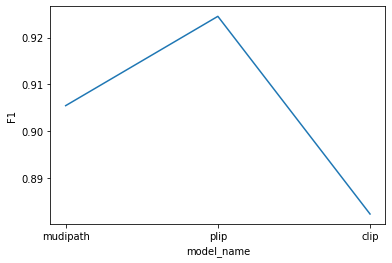

In [19]:
# Plot the metrics you care about
import seaborn as sns
sns.lineplot(x="model_name", y="F1", data=result_df, estimator="max", ci=None)